In [1]:
import os
import sys

HOME = f'{os.getcwd().replace("notebook", "")}'
sys.path.insert(0, HOME)

import time
import keras
import matplotlib.pyplot as plt

from config.paths import TRAIN_PATH
from config.paths import MODELS_PATH

from config.models import EPOCHS
from config.models import CONV_FILTERS
from config.models import CONV_KERNEL
from config.models import LSTM_FILTERS
from config.models import LSTM_KERNEL
from config.models import PADDING
from config.models import SIGMOID
from config.models import RELU
from config.models import STRIDES
from config.models import LOSS
from config.models import LEARNING_RATE
from config.models import EPSILON

from lib.generators import ForwardDataGenerator

In [2]:
train_set = ForwardDataGenerator(TRAIN_PATH, shuffle_at_start=True)

In [3]:
model = keras.models.Sequential()
# Input layer
model.add(keras.layers.InputLayer(input_shape=(ForwardDataGenerator._LOOKBACK, ForwardDataGenerator._IMAGE_HEIGHT, ForwardDataGenerator._IMAGE_WIDTH, 1)))
# TimeDistributed Conv2D layer
model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(CONV_FILTERS, CONV_KERNEL, activation=RELU, strides=STRIDES, padding=PADDING)))
model.add(keras.layers.LayerNormalization())
# ConvLSTM2D layer
model.add(keras.layers.ConvLSTM2D(LSTM_FILTERS, LSTM_KERNEL, padding=PADDING, return_sequences=False))  # return_sequences=False because we want only the last frame representation
model.add(keras.layers.LayerNormalization())
# Conv2DTranspose layers and output layer
model.add(keras.layers.Conv2DTranspose(CONV_FILTERS, CONV_KERNEL, activation=RELU, strides=STRIDES, padding=PADDING))
model.add(keras.layers.LayerNormalization())
model.add(keras.layers.Conv2D(1, CONV_KERNEL, activation=SIGMOID, padding=PADDING))
# Model compilation and training
print(model.summary())
model.compile(loss=LOSS, optimizer=keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON))
start = time.time()
history = model.fit(train_set, batch_size=ForwardDataGenerator._BATCH_SIZE, epochs=EPOCHS, shuffle=False)  # Assuming train_set is correctly formatted
end = time.time()
duration_seconds = int(end - start)
duration_minutes, leftover_seconds = duration_seconds // 60, duration_seconds % 60
print(f'Training took {duration_minutes} min {leftover_seconds} s')
model.save(f'{MODELS_PATH}lstm-convolutional-autoencoder-forward.hdf5')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 5, 44, 64, 32)     544       
 ributed)                                                        
                                                                 
 layer_normalization (Layer  (None, 5, 44, 64, 32)     64        
 Normalization)                                                  
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 44, 64, 16)        27712     
                                                                 
 layer_normalization_1 (Lay  (None, 44, 64, 16)        32        
 erNormalization)                                                
                                                                 
 conv2d_transpose (Conv2DTr  (None, 88, 128, 32)       8224      
 anspose)                                               

/Users/gil-arnaudcoche/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


dict_keys(['loss'])


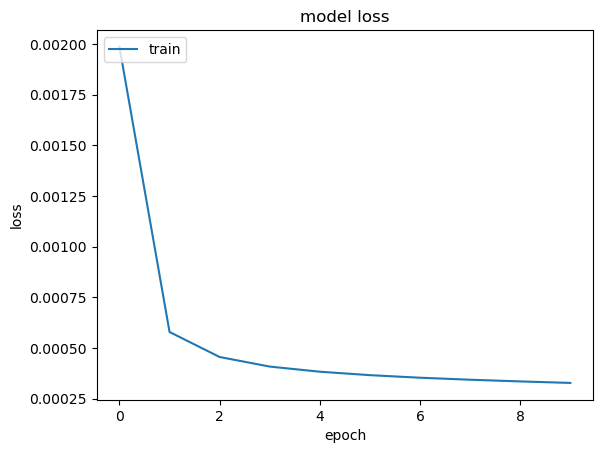

In [4]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()